# Questions for today

- How do we handle class imbalance in deaths? This makes it difficult to see which features it correlates with
- Do we include the target variable in outlier detection? In Mahalanobis? What about categorical features?
- Is it possible / helpful to break our ECG arrays into batches for ECG processing?
- Can we use the target variable to select a subset of the data?


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import scipy.signal as signal
import seaborn as sns
from scipy.spatial import distance
from statsmodels.tsa.seasonal import STL
import neurokit2 as nk

# Reading in Data

First, we read in data from the **vitaldb** dataset, which is an open source Python dataset. We load in patient information (not time series) and tracks, which is a list of waveform objects for each patient.

In [2]:
df_info = pd.read_csv("https://api.vitaldb.net/cases")
df_ids = pd.read_csv("https://api.vitaldb.net/trks")

We select the non-waveform variables we want to use for our analysis. In addition to the unique identifier `subjectid`, we chose age, height, weight, sex, operation start and end time, and surgical approach as our features. For our target variable, we have two options, and we are still deciding which one we want to use. 

Option 1, `death_inhosp`, is a boolean variable representing whether the patient died in the hospital. This is a particularly consequential target variable, but there is a major class imbalance here, with less than 1% of patients dying in the hospital. 

Option 2, `icu_days`, is the number of days a patient spends in the ICU (intensive care unit) after surgery. There is less of a class imbalance here, but ICU stays are not solely determined by adverse events during surgery and also are not necessarily always correlated with adverse outcomes.

This dataset is incredibly large, and we already know that death from a surgery is incredibly unlikely. One idea we have to reduce the class imbalance is to take some subset of the data representing only high-risk surgeries or high-risk patients. 

In [3]:
info = df_info[['subjectid', 'age', 'height', 'weight', 'sex', 'opstart', 'opend', 'approach', 'icu_days', 'death_inhosp']].copy()
info.head()

,subjectid,age,height,weight,sex,opstart,opend,approach,icu_days,death_inhosp
0,5955,77.0,160.2,67.5,M,1668,10368,Open,0,0
1,2487,54.0,167.3,54.8,M,1721,14621,Open,0,0
2,2861,62.0,169.1,69.7,M,1090,3010,Videoscopic,0,0
3,1903,74.0,160.6,53.0,M,2522,17822,Videoscopic,1,0
4,4416,66.0,171.0,59.7,M,2591,20291,Open,13,0


# Data Cleaning/Initial Statistical Exploration 


First, we did some initial data preprocessing. This included changing boolean variables like `sex` and `death_inhosp` from True/False to 0/1, combining OP start and end times into a new variable `OP_time` representing total time in the operating room, and using one-hot encoding on the `approach` feature. We also intriduced a new option for a target variable, `icu`, which is a boolean 0/1 for whether the patient went to the ICU after surgery, as opposed to how many days they spent there.

In [4]:
info_new = info[['subjectid']].copy()
info_new['Age'] = info['age']
info_new['Ht'] = info['height']
info_new['Wt'] = info['weight']
info_new.loc[:,'Sex'] = info.loc[:,'sex'].apply(lambda x: 1 if x == 'F' else 0)
info_new['OP_time'] = (info['opend'] - info['opstart'])/60
one_hot_approaches = pd.get_dummies(info['approach'])
info_new = info_new.join(one_hot_approaches)
info_new['icu_days'] = info['icu_days']
info_new['icu'] = (info['icu_days'] >= 1).apply(lambda x: 1 if x == True else 0)
info_new['death_inhosp'] = info['death_inhosp']

info_new.head()

,subjectid,Age,Ht,Wt,Sex,OP_time,Open,Robotic,Videoscopic,icu_days,icu,death_inhosp
0,5955,77.0,160.2,67.5,0,145.0,1,0,0,0,0,0
1,2487,54.0,167.3,54.8,0,215.0,1,0,0,0,0,0
2,2861,62.0,169.1,69.7,0,32.0,0,0,1,0,0,0
3,1903,74.0,160.6,53.0,0,255.0,0,0,1,1,1,0
4,4416,66.0,171.0,59.7,0,295.0,1,0,0,13,1,0


Next, for all of our continuous numerical features, we plotted histograms to visualize the initial distrubution. We found that all of our features were unimodal, and that age, height, and weight were roughly normally distributed. We plotted `icu_days` on a log scale to better visualize the distribution, since the majority of patients spent 0 days in the ICU.

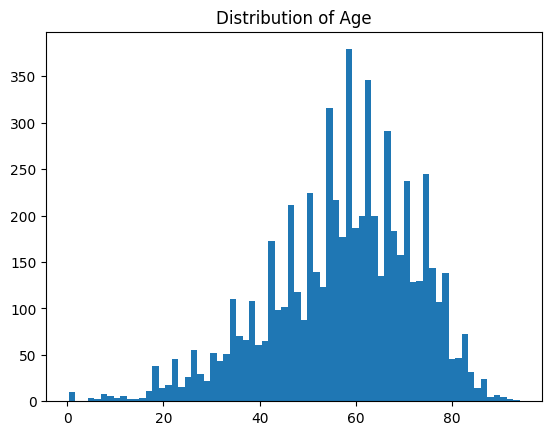

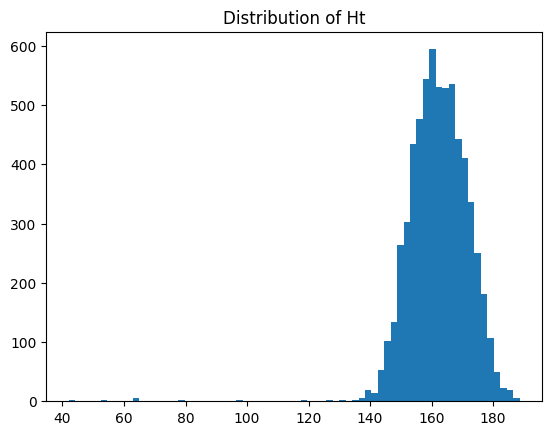

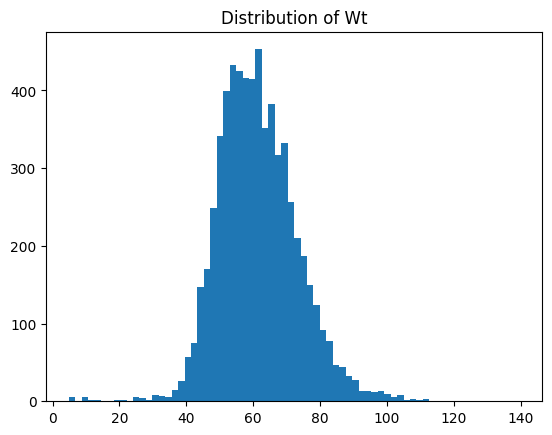

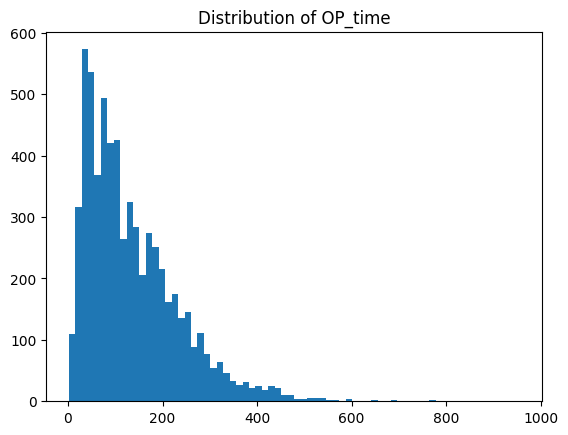

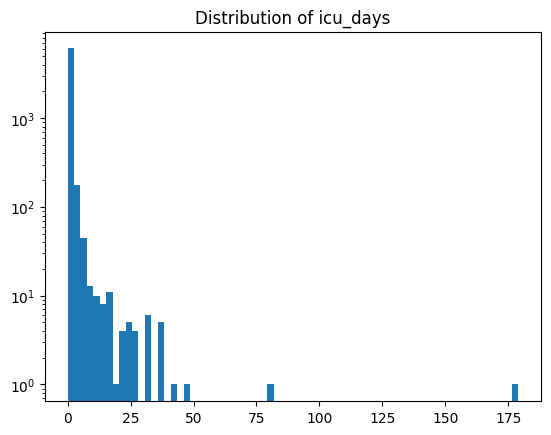

In [5]:
for var in ['Age','Ht','Wt','OP_time', 'icu_days']:
    plt.figure()
    var_unique, counts = np.unique(info_new[var], return_counts=True)
    if var == 'icu_days':
        plt.hist(info_new[var], bins = 70)
        plt.title(f'Distribution of {var}')
        plt.yscale('log')
        plt.show()
    else:
        plt.hist(info_new[var], bins = 70)
        plt.title(f'Distribution of {var}')
        plt.show()

We also plotted some descriptive statistics for all of our variables. For our categorical variables, we printed the mode and class balance, and for our continuous numerical variables, we printed the mean and standard deviation. The class imbalance in our target variables is clear here.

In [6]:
for var in ['Age','Ht','Wt','Sex','OP_time', 'Open', 'Robotic', 'Videoscopic', 'icu_days', 'icu', 'death_inhosp']:
    print(f'For variable {var}:')
    if var in ['Sex', 'Open', 'Robotic', 'Videoscopic', 'icu', 'death_inhosp']:
        print(f'mode={stats.mode(info_new[var]).mode[0]}')
        print(f'class balance: {np.sum(info_new[var])} to {len(info_new)-np.sum(info_new[var])}\n')
    else:
        print(f'mean={np.mean(info_new[var])}')
        print(f'standard deviation={np.std(info_new[var])}\n')

For variable Age:
mean=57.2964934251722
standard deviation=14.975289087630228

For variable Ht:
mean=162.18883218534754
standard deviation=9.904554043925097

For variable Wt:
mean=61.48492172824045
standard deviation=11.944200387476357

For variable Sex:
mode=0
class balance: 3145 to 3243

For variable OP_time:
mean=135.98546232519305
standard deviation=101.15376625280668

For variable Open:
mode=1
class balance: 3365 to 3023

For variable Robotic:
mode=0
class balance: 269 to 6119

For variable Videoscopic:
mode=0
class balance: 2754 to 3634

For variable icu_days:
mean=0.5527551659361303
standard deviation=3.4120403936109827

For variable icu:
mode=0
class balance: 1204 to 5184

For variable death_inhosp:
mode=0
class balance: 57 to 6331



We plotted a correlation matrix of all of the variables to get a sense of the relationships between the variables.

Text(0.5, 1.0, 'Correlation Matrix - All Variables')

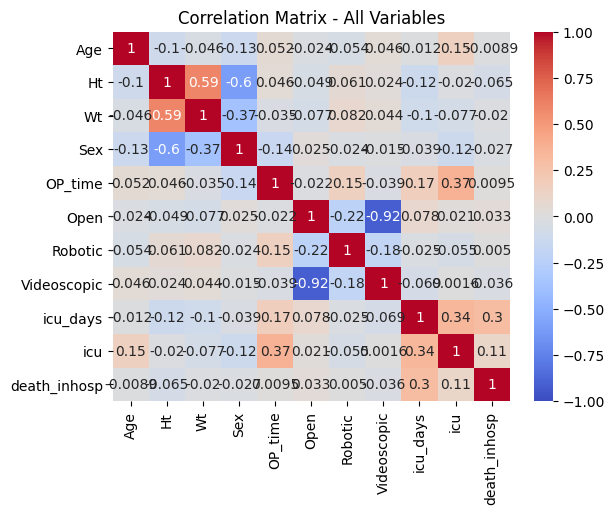

In [7]:
cor_mat = info_new[['Age','Ht','Wt','Sex','OP_time', 'Open', 'Robotic', 'Videoscopic', 'icu_days', 'icu', 'death_inhosp']].corr()
sns.heatmap(cor_mat,cmap='coolwarm',vmin=-1.0,vmax=1.0,annot=True)
plt.title('Correlation Matrix - All Variables')

We removed `Open`, `Robotic`, and `Videoscopic` from our correlation matrix because they really only correlated with each other. We may add them back in later, but this also made for a more comprehensible visualization.

Text(0.5, 1.0, 'Correlation Matrix - Reduced')

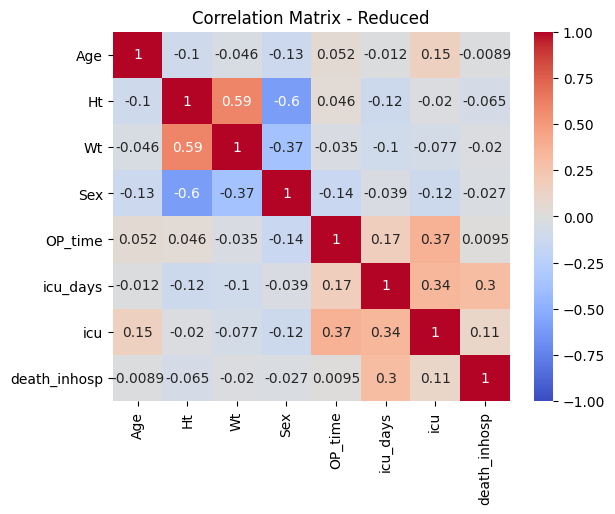

In [8]:
# Remove variables with low correlations
cor_mat = info_new[['Age','Ht','Wt','Sex','OP_time', 'icu_days', 'icu', 'death_inhosp']].corr()
sns.heatmap(cor_mat,cmap='coolwarm',vmin=-1.0,vmax=1.0,annot=True)
plt.title('Correlation Matrix - Reduced')

# Outlier Detection

Next, we moved on to the outlier detection step. We used the Mahalanobis distance method for outlier detection. We felt it was valid to use this method because all of our individual distributions were unimodal, so we assumed our overall data to be unimodal. We know that the Mahalanobis distance method works poorly on multimodal data, but is a good metric for unimodal data. We are also conscious that our data is high-dimensional, so if we add more features, we will need to consider if the Mahalanobis distance metric is still valid. 

In [9]:
num_data = info_new[['Age','Ht','Wt','Sex','OP_time']]
mu = list(np.mean(num_data))
iv = np.linalg.inv(num_data.cov())

In [10]:
info_new['Mahalanobis'] = num_data.apply(lambda x: distance.mahalanobis(x,mu,iv),axis=1)

In [11]:
# Remove data points with top 5% mahalanobis distance
thresh = np.quantile(list(info_new['Mahalanobis']),0.95)
data = info_new[info_new['Mahalanobis'] < thresh]
print(f'We removed {len(info_new[info_new["Mahalanobis"] >= thresh])} outliers, leaving {len(data)} points remaining')

We removed 320 outliers, leaving 6068 points remaining


Text(0.5, 1.0, 'Correlation Matrix - Post Outlier Removal')

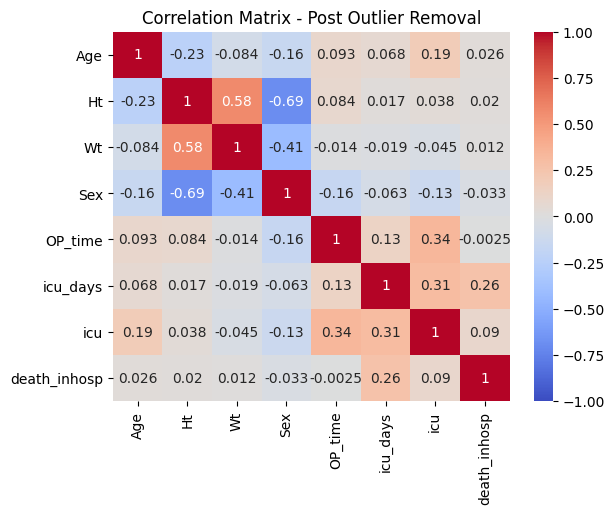

In [12]:
# evaluate change in correlation between height and age
cor_mat_new = data[['Age','Ht','Wt','Sex','OP_time', 'icu_days', 'icu', 'death_inhosp']].corr()
sns.heatmap(cor_mat_new,cmap='coolwarm',vmin=-1.0,vmax=1.0,annot=True)
plt.title('Correlation Matrix - Post Outlier Removal')

# Age Stratification

Because of potential for different physical characteristics, we realized that there is probably a need to treat people from different age groups differently when performing outlier detection methods. To do this, we introduced three age classes: children (18 and under), adult (19-64), and elderly (65 and older). We redid everything from the previous section, but stratified by age.

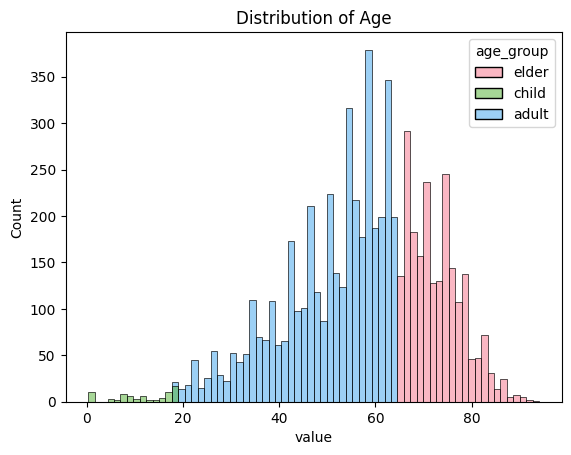

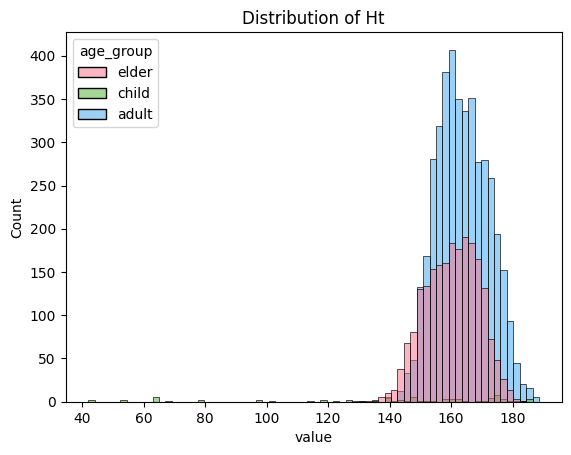

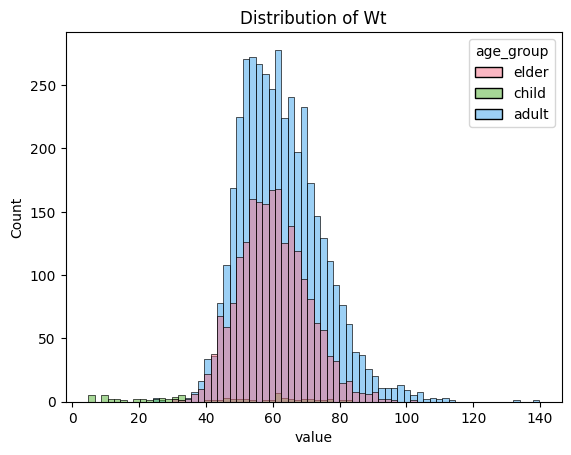

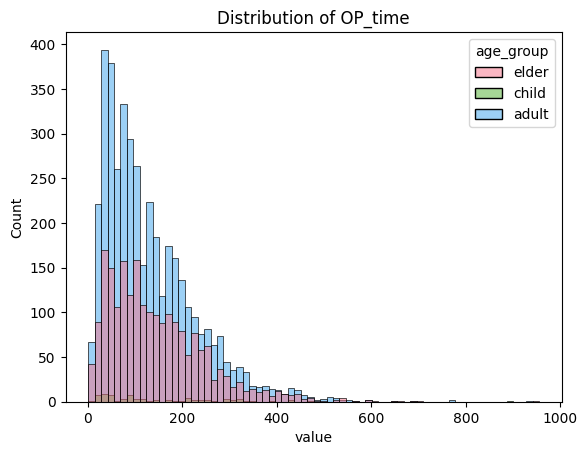

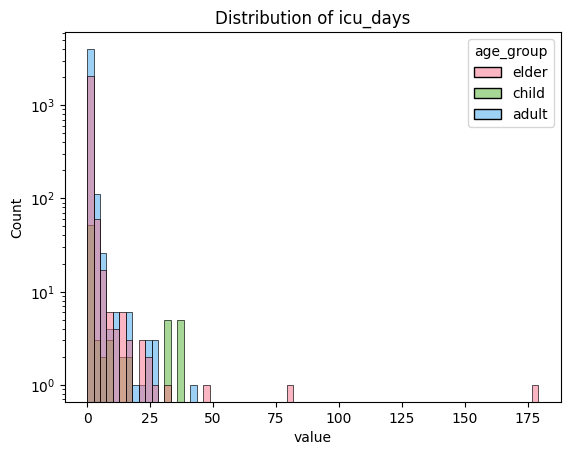

In [13]:
info_new['age_group'] = info_new['Age'].apply(lambda x: 'child' if x < 19 else ('elder' if x > 64 else 'adult'))

for var in ['Age','Ht','Wt','OP_time', 'icu_days']:
    to_plot = info_new.melt(id_vars='age_group', value_vars=var, var_name='variable', value_name='value')
    to_plot['age_group'] = pd.Categorical(to_plot['age_group'], categories=reversed(sorted(to_plot['age_group'].unique())), ordered=True)
    palette = sns.color_palette("husl", n_colors=len(to_plot['age_group'].unique()))

    plt.figure()
    sns.histplot(data=to_plot, x='value', hue='age_group', multiple='layer', bins=70, alpha=0.5, palette=palette)
    plt.title(f'Distribution of {var}')
    if var == 'icu_days':
        plt.yscale('log')
    plt.show()

In [14]:
for var in ['Age','Ht','Wt','Sex','OP_time', 'Open', 'Robotic', 'Videoscopic', 'icu_days', 'icu', 'death_inhosp']:
    print(f'\nFor variable {var}:')
    for g in ['child','adult','elder']:
        print(f'In class {g},')
        if var in ['Sex', 'Open', 'Robotic', 'Videoscopic', 'icu', 'death_inhosp']:
            print(f'mode={stats.mode(info_new[info_new["age_group"]==g][var]).mode[0]}')
            print(f'class balance: {np.sum(info_new[info_new["age_group"]==g][var])} to {len(info_new[info_new["age_group"]==g])-np.sum(info_new[info_new["age_group"]==g][var])}\n')
        else:
            print(f'mean={np.mean(info_new[info_new["age_group"]==g][var])}')
            print(f'standard deviation={np.std(info_new[info_new["age_group"]==g][var])}\n')


For variable Age:
In class child,
mean=11.675675675675675
standard deviation=6.0248093120168615

In class adult,
mean=50.184153661464585
standard deviation=10.888893800440728

In class elder,
mean=72.6519311307585
standard deviation=5.484172602364935


For variable Ht:
In class child,
mean=138.98918918918918
standard deviation=40.214057537966866

In class adult,
mean=163.63847779111646
standard deviation=8.383937382770833

In class elder,
mean=160.17812936249422
standard deviation=8.54638486809783


For variable Wt:
In class child,
mean=40.935810810810814
standard deviation=23.001716328837627

In class adult,
mean=62.55960864345739
standard deviation=12.106093865585805

In class elder,
mean=60.10966030711959
standard deviation=10.15585202779337


For variable Sex:
In class child,
mode=0
class balance: 36 to 38

In class adult,
mode=1
class balance: 2241 to 1924

In class elder,
mode=0
class balance: 868 to 1281


For variable OP_time:
In class child,
mean=161.4536036036036
standard de

This time, when we removed outliers, we counted how many were removed from each class. The numbers seemed representative of the class balance, which is good.

In [15]:
data = pd.DataFrame()

for c in ['child','adult','elder']:
    small_data = info_new[info_new['age_group']==c].copy()
    num_data = small_data[['Age','Ht','Wt','Sex','OP_time']]
    mu = list(np.mean(num_data))
    iv = np.linalg.inv(num_data.cov())
    small_data['Mahalanobis'] = num_data.apply(lambda x: distance.mahalanobis(x,mu,iv),axis=1)
    thresh = np.quantile(list(small_data['Mahalanobis']),0.95)
    print(f'removing {len(small_data[small_data["Mahalanobis"] >= thresh])} outliers from {c} class')
    data = pd.concat([data, small_data[small_data['Mahalanobis'] < thresh]], ignore_index=True)

removing 4 outliers from child class
removing 209 outliers from adult class
removing 108 outliers from elder class


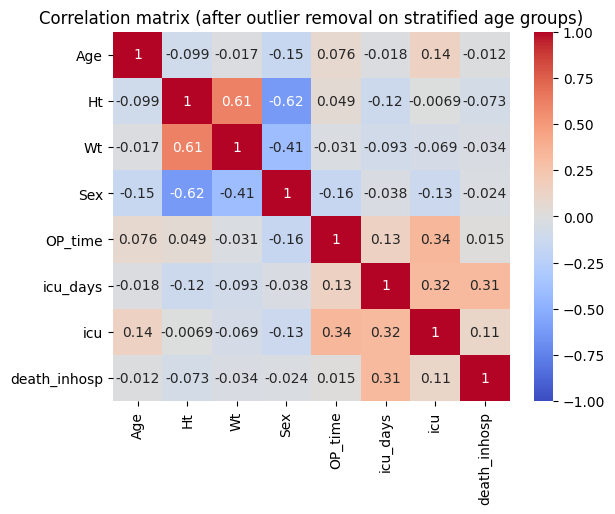

In [16]:
cor_mat_new = data[['Age','Ht','Wt','Sex','OP_time', 'icu_days', 'icu', 'death_inhosp']].corr()
sns.heatmap(cor_mat_new,cmap='coolwarm',vmin=-1.0,vmax=1.0,annot=True)
plt.title('Correlation matrix (after outlier removal on stratified age groups)')
plt.show()

We wanted to explore what relationships were present between our variables according to each class, particularly noting some of the differences in children. We expected age, hwight, and weight to be more correlated in children, but we found it interesting that every feature was more correlated in children. We expect that this is because of the inherent risks associated with surgery for infants.

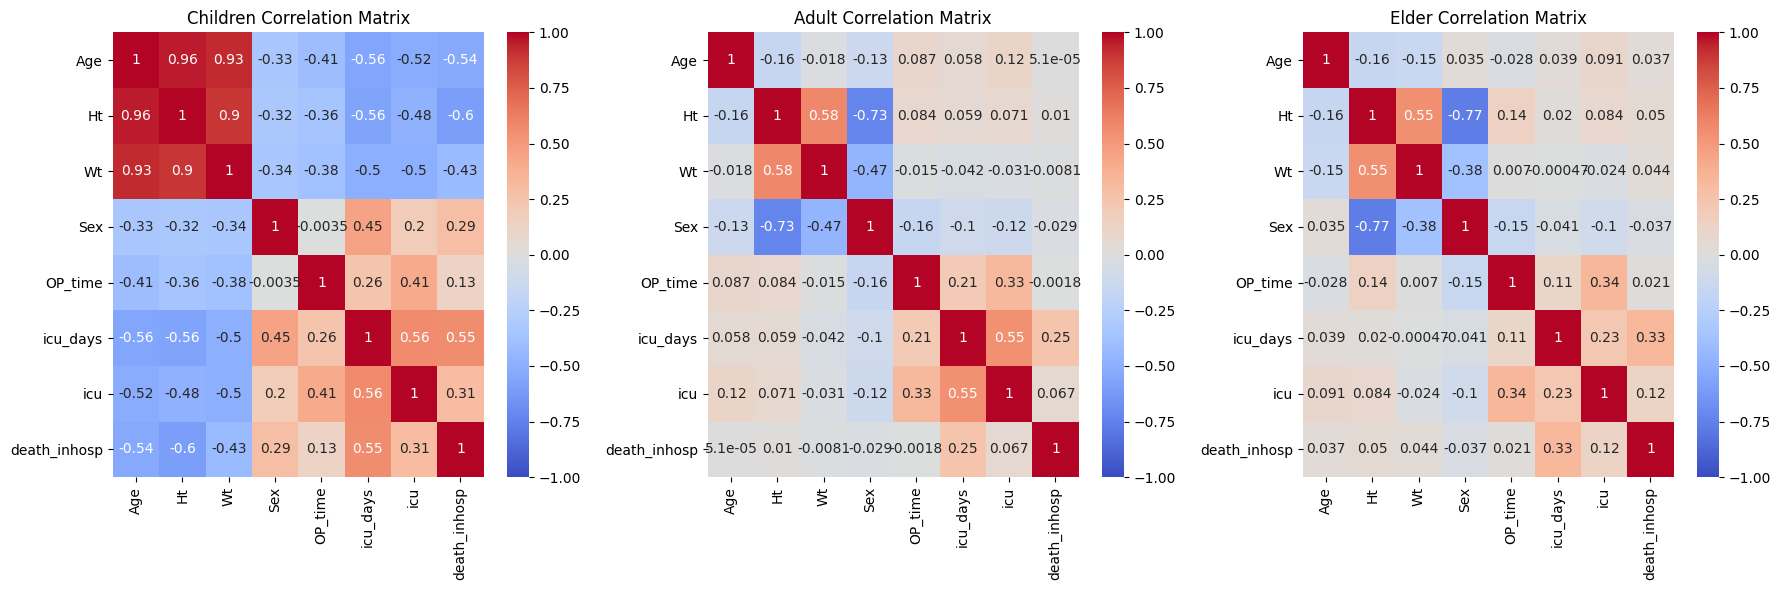

In [17]:
cor_mat_children = data[data['age_group'] == 'child'][['Age','Ht','Wt','Sex','OP_time', 'icu_days', 'icu', 'death_inhosp']].corr()
cor_mat_adults = data[data['age_group'] == 'adult'][['Age','Ht','Wt','Sex','OP_time', 'icu_days', 'icu', 'death_inhosp']].corr()
cor_mat_elders = data[data['age_group'] == 'elder'][['Age','Ht','Wt','Sex','OP_time', 'icu_days', 'icu', 'death_inhosp']].corr()

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

sns.heatmap(cor_mat_children, ax=axs[0], cmap='coolwarm',vmin=-1.0,vmax=1.0, annot=True)
sns.heatmap(cor_mat_adults, ax=axs[1], cmap='coolwarm',vmin=-1.0,vmax=1.0, annot=True)
sns.heatmap(cor_mat_elders, ax=axs[2], cmap='coolwarm',vmin=-1.0,vmax=1.0, annot=True)

axs[0].set_title('Children Correlation Matrix')
axs[1].set_title('Adult Correlation Matrix')
axs[2].set_title('Elder Correlation Matrix')

plt.tight_layout()
plt.show()


# Time Series Outlier Detection (SNUADC ECG)

Next, we wanted to move forward into looking at waveform data. The tracks data from **vitaldb** contained many different measurements from many different devices for many different patients. To simplify things, we decided to focus on one measurement from one device: the ECG reading from the SNUADC device. Still, there were waveforms for 6355 patients just on this measurement and this device.

In [18]:
ecg_info = df_ids[df_ids['tname'] == 'SNUADC/ECG_II']
ecg_info

,caseid,tname,tid
41,1,SNUADC/ECG_II,8c9161aaae8cb578e2aa7b60f44234d98d2b3344
122,2,SNUADC/ECG_II,62204d727b2e31e42f9602c054c7d9e598b2db05
198,3,SNUADC/ECG_II,2012a9532285255e1051e9be389d69e2778373ba
279,4,SNUADC/ECG_II,be29325ee538657798f5c804bf72596fb3fd47ea
366,5,SNUADC/ECG_II,3431cd35ca4bc15b6de13e4c49b2db56e6bc5a37
...,...,...,...
486118,6384,SNUADC/ECG_II,38fda47c2e06534015012c131657edd66e36f4d2
486191,6385,SNUADC/ECG_II,0e030d618ae6101448128542f7b2964e66ad6272
486266,6386,SNUADC/ECG_II,7f4f673135fff8b4474dcbd852c774aad89e3c0d
486342,6387,SNUADC/ECG_II,66401ffc5c1ef2d8904e021f55c2d745e2bd5936


In [19]:
def get_data_for(tid):
    data = pd.read_csv(f"https://api.vitaldb.net/{tid}")
    arr = np.array(data['SNUADC/ECG_II'])
    time_array = np.linspace(0, np.array(data['Time'])[-1], len(data))
    return time_array, arr

We started by just looking at one patient to speed up calculations and better understand the waveform data and what we were trying to accomplish. After initially looking at a plot of the waveform, we found that the beginning and end showed unusual behavior. Because of this, we decided to clip off the first and last 15 minutes of each surgery so that we could exclusively focus on the central portion. We also made an even smaller section, which was 15,000 data points (or about 30 seconds), which we used in intermediate steps when visualizing specific beats was helpful.

In [28]:
ecg_time, ecg_data = get_data_for("cedfc6b4610363ed0ac5a4ac4a23e007bda34fe6")
fs = 500
valid_data = ecg_data[(ecg_time > 900) & (ecg_time < ecg_time[-1]-900)]
valid_time = ecg_time[(ecg_time > 900) & (ecg_time < ecg_time[-1]-900)]
small_time = valid_time[15000:30000]
small_data = valid_data[15000:30000]

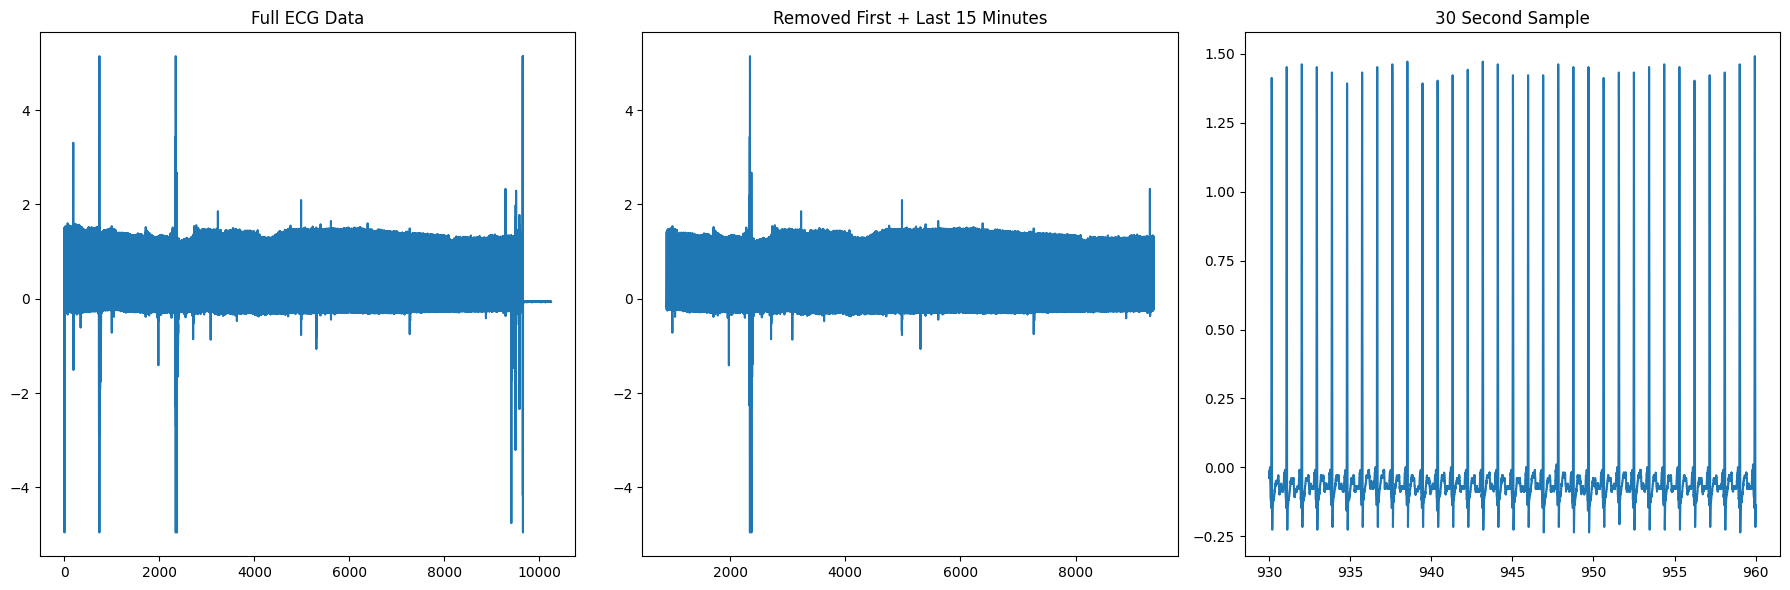

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].plot(ecg_time,ecg_data)
axs[0].set_title('Full ECG Data')
axs[1].plot(valid_time,valid_data)
axs[1].set_title('Removed First + Last 15 Minutes')
axs[2].plot(small_time,small_data)
axs[2].set_title('30 Second Sample')

plt.tight_layout()
plt.show()

## Option 1: STL

First, we tried using trend, seasonal, and residual decomposition to analyze these waveforms, which was the method we discussed in class. We found that even on only 30 seconds of data, and only for one patient, this was quite slow, and it also did not seem to work as we wanted it to. We expected a constant trend and a seasonality matching the original waveform, but what we found was that the residual was also capturing much of the periodic behavior of the waveform. After some research, we found that STL decomposition is not recommended for ECG data because it is actually made up of a composition of multiple waveforms. 

In [30]:
periodicity = int(np.round(1 / (valid_time[1] - valid_time[0])))
stl = STL(small_data, period = periodicity)
ts_decomposed = stl.fit()

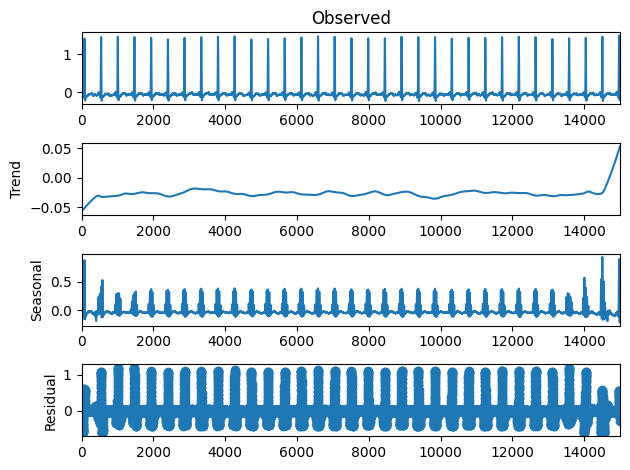

In [31]:
ts_decomposed.plot()
plt.show()

## Option 2: FFT

After learning that ECG data is made up of multiple waveforms, we thought of using some sort of Fourier decomposition. Ultimately, however, we did not end up spending much time on this method.

Text(0.5, 1.0, 'FFT for 30 seconds of ECG data')

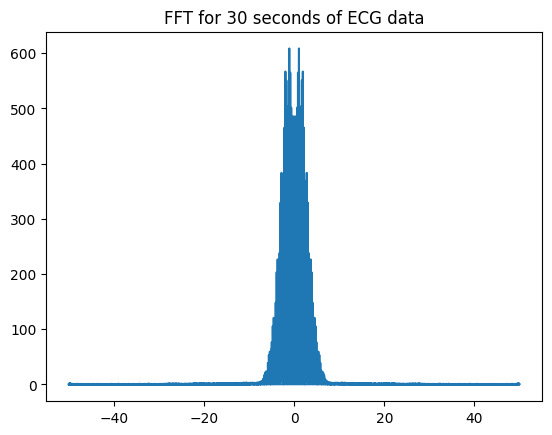

In [32]:
fft_signal = np.fft.fft(small_data)
freqs = np.fft.fftfreq(len(small_data), 0.01)
plt.plot(freqs, np.abs(fft_signal))
plt.title('FFT for 30 seconds of ECG data')

## Option 3: RR Intervals

The last method we explored for analyzing our waveforms was looking at the RR intervals (https://imotions.com/blog/learning/best-practice/heart-rate-variability/). The waveform from ECG data is made up of three parts, known as the QRS complex. The RR interval is the time between two R peaks. There is a lot more interesting stuff to explore in this article, but for now, we just focused on finding RR intervals and doing some basic measures on them.


First, we applied a band-pass filter to our data to smooth it a bit before diving in.

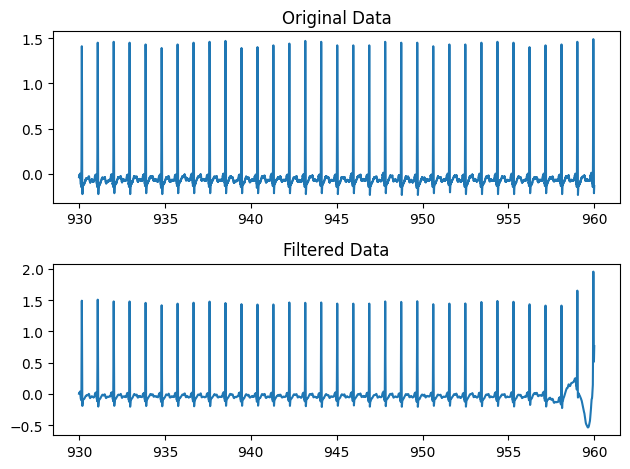

In [35]:
lowcut = 0.5
highcut = 40.0
order = 4
nyquist = 0.5 * fs
low = lowcut / nyquist
high = highcut / nyquist
b, a = signal.butter(order, [low,high], btype='band')
filtered = signal.filtfilt(b,a,small_data)

plt.figure()
plt.subplot(2,1,1)
plt.plot(small_time, small_data)
plt.title('Original Data')
plt.subplot(2,1,2)
plt.plot(small_time, filtered)
plt.title('Filtered Data')
plt.tight_layout()
plt.show()

Next, we used the `neurokit2` package to process the waveform and find the RR intervals. We did this first with our 30 second sample and then with our full waveform (minus the first and last 15 minutes).

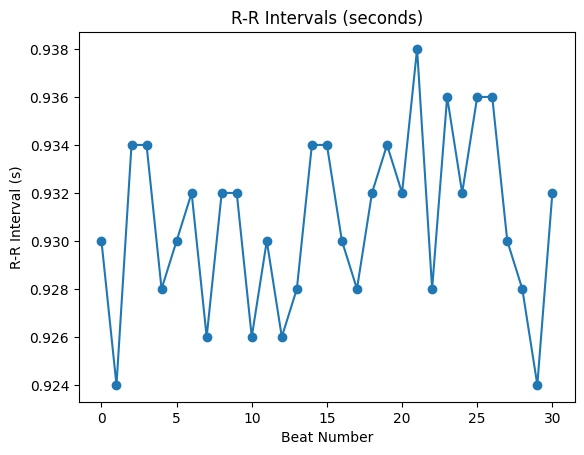

In [36]:
ecg_cleaned = nk.ecg_clean(filtered, sampling_rate=500, method="neurokit")
ecg_signals, ecg_info = nk.ecg_process(ecg_cleaned, sampling_rate=500)
rpeaks = ecg_info['ECG_R_Peaks']
rr_intervals = np.diff(rpeaks) / 500

plt.plot(rr_intervals, marker='o', linestyle='-')
plt.title("R-R Intervals (seconds)")
plt.xlabel("Beat Number")
plt.ylabel("R-R Interval (s)")
plt.show()

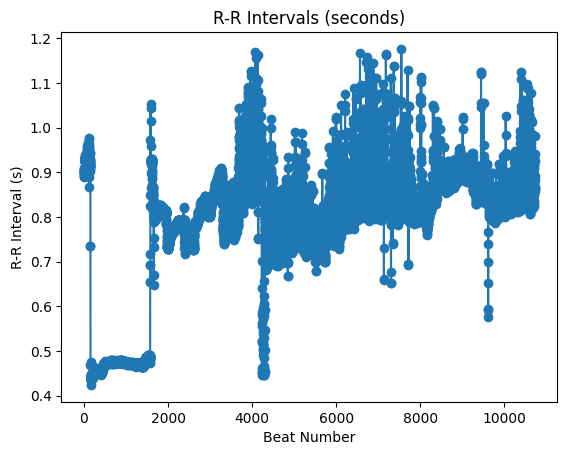

In [37]:
filtered = signal.filtfilt(b,a,valid_data)
ecg_cleaned = nk.ecg_clean(filtered, sampling_rate=500, method="neurokit")
ecg_signals, ecg_info = nk.ecg_process(ecg_cleaned, sampling_rate=500)
rpeaks = ecg_info['ECG_R_Peaks']
rr_intervals = np.diff(rpeaks) / 500
plt.plot(rr_intervals, marker='o', linestyle='-')
plt.title("R-R Intervals (seconds)")
plt.xlabel("Beat Number")
plt.ylabel("R-R Interval (s)")
plt.show()

Before doing anything with the data, we ran it through a 50-point moving average (0.1 second at our 500 Hz sampling rate) to filter out small blips and focus on more ongoing outliers.

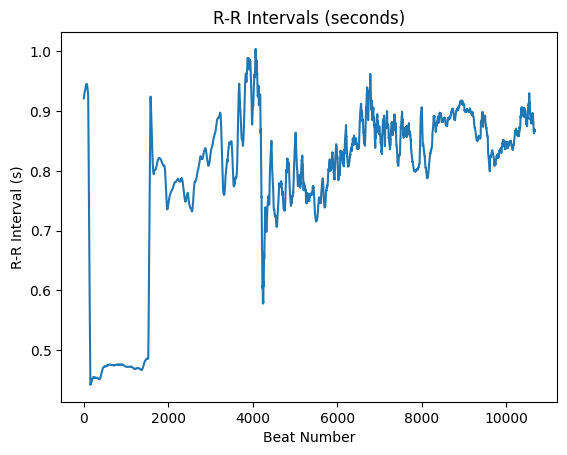

In [38]:
ma = np.convolve(rr_intervals, np.ones(50)/50)
plt.plot(ma[50:-50], linestyle='-')
plt.title("R-R Intervals (seconds)")
plt.xlabel("Beat Number")
plt.ylabel("R-R Interval (s)")
plt.show()

We want to turn the waveform data into another feature that we can use in our original model. We had two ideas for how to create this feature.

1. Big jumps: find the difference array and set some threshold for a 'big jump', then take the number of big jumps found in the difference array. This represents the number of drastic changes to a patient's heart rate that occurred during the surgery.

2. Deviation from mean: Find the mean of the R-R intervals, then find the percentage of points that fall outside 2 standard deviations of the mean. This can be thought of as the percentage of time that the patient had within an abnormal heart rate zone. We will think about a way to make sure the mean itself is not affected by these outliers.

In [39]:
ma_sampled = [ma[15*i] for i in range(int(len(ma)/15))]
diff = np.diff(ma_sampled)
thresh = 0.2
print(f'There are {len(diff[diff>thresh])} big jumps')

There are 3 big jumps


In [40]:
mu = np.mean(ma)
std = np.std(ma)
print(f'{100*len(ma[(ma>mu+2*std) | (ma<mu-2*std)])/len(ma):0.2f}% of points lie outside the normal zone')

13.33% of points lie outside the normal zone
